In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from numpy import linalg as LA
import os, pickle, gzip

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as plticker
from matplotlib import cm
import gzip

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

KITTI_HOME = '/home/kreimer/KITTI'

In [3]:
def read_dts(file):
    dts = []
    with open(file, 'r') as f:
        for num, line in enumerate(f):
            pose = np.array([float(val) for val in line.split()]).reshape(3,4)
            pose = np.vstack((pose, [0, 0, 0, 1]))
            try:
                delta = np.dot(LA.inv(ppose), pose)
            except NameError:
                ppose = pose
                continue
            dt = delta[:3,3]
            dts.append(dt)

            ppose = pose
    return dts

In [20]:
def predict_seq(seq):
    poses_file = os.path.join('data', 'paths', '%s.txt' % seq)
    dts = np.array(read_dts(poses_file))
    ndts = np.linalg.norm(dts, axis=1)
    scale = ndts[0]
    y = ndts / scale
    
    # load the precomputed features
    with gzip.open(os.path.join('data', 'features', '%s_1_6_4_300.pklz' % seq), 'rb') as fd:
        pairs, feat, dts = pickle.load(fd)

    # load the model
    with gzip.open(os.path.join('data', 'models', 'ETR_1_6_4_300.pklz'), 'rb') as fd:
        rf = pickle.load(fd)

    X = np.array(feat)
    y_pred = rf.predict(X)

    # compute scale estimate
    scale_est = np.dot(y_pred, y).sum()/np.dot(y, y).sum()
    return (scale_est, scale)

seq 00 estimated scale: 0.738, true scale: 0.674
seq 01 estimated scale: 0.474, true scale: 1.02
seq 02 estimated scale: 1.36, true scale: 1.55
seq 03 estimated scale: 1.21, true scale: 0.966
seq 04 estimated scale: 0.957, true scale: 1.33
seq 05 estimated scale: 0.629, true scale: 0.568
seq 06 estimated scale: 1.05, true scale: 1.21
seq 07 estimated scale: 0.114, true scale: 0.0897
seq 08 estimated scale: 0.877, true scale: 0.777
seq 09 estimated scale: 0.251, true scale: 0.294


<IPython.core.display.Javascript object>


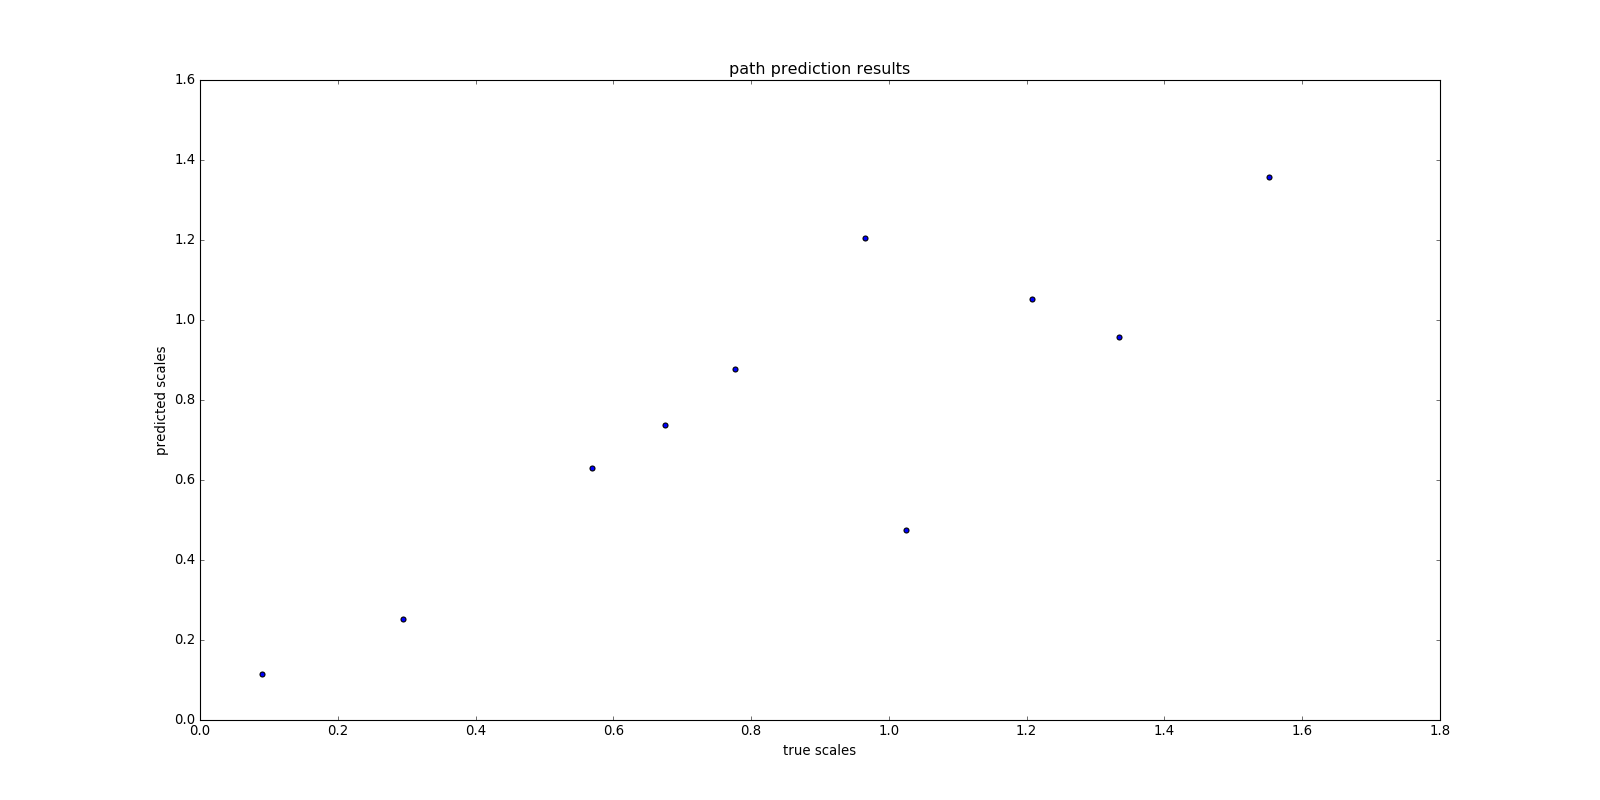

In [23]:
pred_scales = []
true_scales = []
for seq in ['%02d' % s for s in range(10)]:
    predicted_scale, true_scale = predict_seq(seq)
    pred_scales.append(predicted_scale)
    true_scales.append(true_scale)
    print('seq %s estimated scale: %0.3g, true scale: %0.3g' % (seq, predicted_scale, true_scale))

<IPython.core.display.Javascript object>


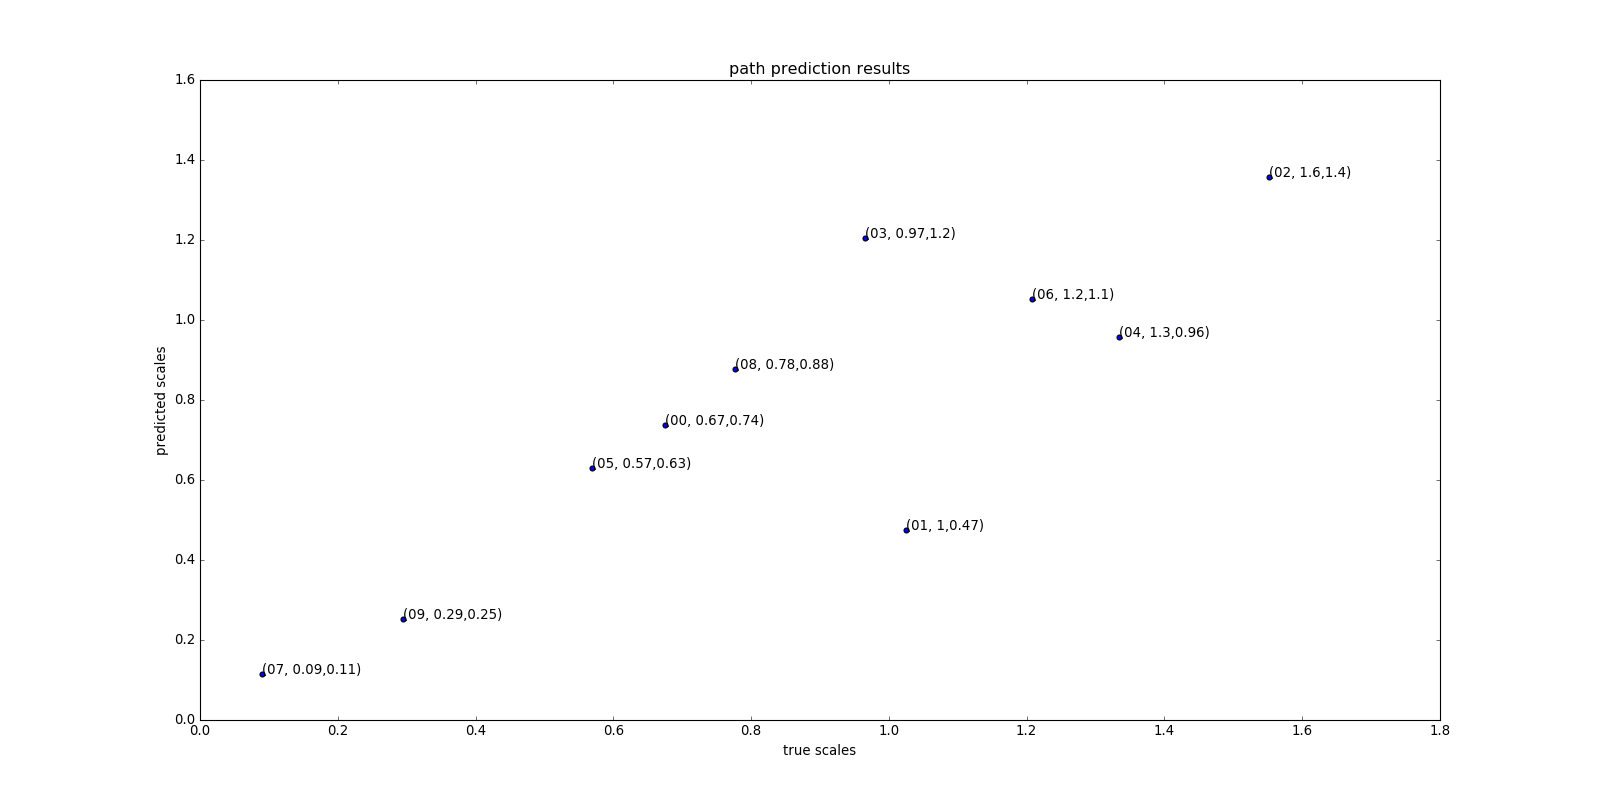

In [30]:
fig, ax = plt.subplots()
ax.scatter(true_scales, pred_scales)
plt.xlabel('true scales')
plt.ylabel('predicted scales')
plt.title('path prediction results')
for s, true_scale, pred_scale in zip(range(10), true_scales, pred_scales):
    ax.annotate('(%02d, %.2g,%.2g)' % (s, true_scale, pred_scale), (true_scale, pred_scale))